# **Installisions**

In [2]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 98.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninsta

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [30]:
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'
file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=494933bc-7a17-4379-ae68-ec8e8fd3f984
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:04<00:00, 157MB/s]  


'sepsis_data.csv'

In [31]:
def load_and_preprocess_data(filepath):
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns
                  if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])
    cols_to_drop = [col for col in df.columns if 'observed' in col.lower()]
    cols_to_drop.extend(['HospAdmTime', 'Age'])
    cols_to_drop = list(set([col for col in cols_to_drop if col in df.columns]))
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())
    df[cols_to_impute] = df[cols_to_impute].fillna(0)
    return df

In [32]:
df = load_and_preprocess_data("/kaggle/working/sepsis_data.csv")

In [33]:
def create_patient_sequences(df, sequence_length=10):
    try:
        sequences = []
        labels = []
        
        feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
        
        for pid, group in df.groupby('Patient_ID'):
            features = group[feature_cols].values
            sepsis_labels = group['SepsisLabel'].values
            
            if len(features) < sequence_length:
                pad_len = sequence_length - len(features)
                features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
                sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])
            
            for i in range(0, len(features) - sequence_length + 1, 1):
                seq = features[i:i+sequence_length]
                label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
                sequences.append(seq)
                labels.append(label)
        
        X = np.array(sequences, dtype=np.float32)
        y = np.array(labels, dtype=np.int8)
        
        print(f"Created {len(X)} sequences")
        print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
        return X, y, feature_cols
    except Exception as e:
        print(f"Error in create_patient_sequences: {e}")
        raise
X, y, feature_cols = create_patient_sequences(df, sequence_length=10)

Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


In [34]:
def decision_tree_undersampling(X, y, target_samples=35000):
    try:
        print(f"\nUndersampling majority class to {target_samples} samples...")
        
        majority_indices = np.where(y == 0)[0]
        
        if len(majority_indices) <= target_samples:
            return X, y
        
        np.random.shuffle(majority_indices)
        subset_indices = majority_indices[:min(50000, len(majority_indices))]
        
        X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y[subset_indices], X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        sample_importances = dt.feature_importances_.sum()
        selected_indices = np.random.choice(subset_indices, size=target_samples, replace=False)
        
        minority_indices = np.where(y == 1)[0]
        final_indices = np.concatenate([selected_indices, minority_indices])
        
        return X[final_indices], y[final_indices]
    except Exception as e:
        print(f"Error in decision_tree_undersampling: {e}")
        raise

In [35]:
def decision_tree_upsampling(X, y, target_samples=27000):
    try:
        print(f"\nUpsampling minority class to {target_samples} samples...")
        
        minority_indices = np.where(y == 1)[0]
        
        if len(minority_indices) >= target_samples:
            return X, y
        
        num_to_generate = target_samples - len(minority_indices)
        
        X_flattened = X.reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y, X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        synthetic_samples = []
        for _ in range(num_to_generate):
            base_sample = X[np.random.choice(minority_indices)]
            
            synthetic_sample = base_sample.copy()
            for t in range(X.shape[1]):
                for f in range(X.shape[2]):
                    if dt.feature_importances_[f] > 0.01:
                        noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                        synthetic_sample[t, f] += noise
            
            synthetic_samples.append(synthetic_sample)
        
        synthetic_samples = np.array(synthetic_samples)
        
        X_upsampled = np.concatenate([X, synthetic_samples])
        y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])
        
        return X_upsampled, y_upsampled
    except Exception as e:
        print(f"Error in decision_tree_upsampling: {e}")
        raise

In [36]:
X, y = decision_tree_undersampling(X, y, target_samples=35000)
X, y = decision_tree_upsampling(X, y, target_samples=27000)


Undersampling majority class to 35000 samples...

Upsampling minority class to 27000 samples...


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [38]:
def build_resnet_model(input_shape, dropout_rate=0.3, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    def res_block(x, filters):
        shortcut = x
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
        
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        
        if shortcut.shape[-1] != filters:
            shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)
        
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x
    
    x = res_block(x, 64)
    x = res_block(x, 128)
    x = res_block(x, 128)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model


Epoch 1/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6545 - auc_1: 0.6964 - loss: 0.6336 - val_accuracy: 0.7001 - val_auc_1: 0.7682 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 2/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7124 - auc_1: 0.7720 - loss: 0.5688 - val_accuracy: 0.7164 - val_auc_1: 0.7913 - val_loss: 0.5480 - learning_rate: 0.0010
Epoch 3/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7292 - auc_1: 0.7951 - loss: 0.5455 - val_accuracy: 0.7281 - val_auc_1: 0.8048 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 4/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7415 - auc_1: 0.8138 - loss: 0.5240 - val_accuracy: 0.7368 - val_auc_1: 0.8179 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 5/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7574 - auc_1: 0.8321 - loss: 0.5005 - val_accuracy: 0.7500 - val_auc_1: 0.8328 - val_loss: 0.4974 - learning_rate: 0.0010
Epoch 6/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/

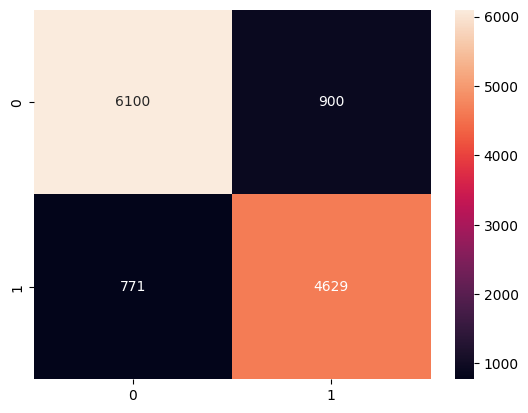

In [39]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_resnet_model(input_shape)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluation
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import time

In [41]:
np.random.seed(42)
minority_indices = np.where(y == 1)[0]
majority_indices = np.where(y == 0)[0]
n_minority = len(minority_indices)

n_minority_half = n_minority // 2
selected_minority = np.random.choice(minority_indices, size=n_minority_half, replace=False)
selected_majority = np.random.choice(majority_indices, size=n_minority_half, replace=False)

subset_indices = np.concatenate([selected_minority, selected_majority])
np.random.shuffle(subset_indices)
X_subset = X[subset_indices]
y_subset = y[subset_indices]
print(f"Subset created: {len(X_subset)} samples (balanced, 50% of original)")

Subset created: 27000 samples (balanced, 50% of original)


In [42]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42
)
X_train_sub_scaled = scaler.transform(X_train_sub.reshape(-1, X_train_sub.shape[-1])).reshape(X_train_sub.shape)
X_val_sub_scaled = scaler.transform(X_val_sub.reshape(-1, X_val_sub.shape[-1])).reshape(X_val_sub.shape)


In [43]:
def generate_neighbors(current, bounds, step_size=0.05):
    neighbors = []
    for i in range(len(current)):
        for delta in [-step_size, step_size]:
            neighbor = current.copy()
            neighbor[i] = np.clip(neighbor[i] + delta, bounds[i, 0], bounds[i, 1])
            neighbors.append(neighbor)
    return neighbors

**GWO Optmization**

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt

In [45]:
def gwo_initialize(n_wolves, bounds):
    bounds = np.array(bounds)
    n_dim = bounds.shape[0]
    positions = np.random.uniform(
        low=bounds[:, 0],
        high=bounds[:, 1],
        size=(n_wolves, n_dim)
    )
    return positions, bounds, n_dim

def gwo_evaluate(positions, objective):
    n_wolves = positions.shape[0]
    scores = np.zeros(n_wolves)
    for i in range(n_wolves):
        scores[i] = objective(positions[i])
    return scores

In [46]:

def gwo_update_leaders(positions, scores):
    sorted_idx = np.argsort(scores)
    alpha_pos = positions[sorted_idx[0]].copy()
    alpha_score = scores[sorted_idx[0]]
    
    beta_pos = alpha_pos.copy() if len(sorted_idx) < 2 else positions[sorted_idx[1]].copy()
    delta_pos = alpha_pos.copy() if len(sorted_idx) < 3 else positions[sorted_idx[2]].copy()
    
    return alpha_pos, beta_pos, delta_pos, alpha_score


In [47]:
def gwo_optimize(objective, bounds, n_wolves=10, n_iterations=5):
    positions, bounds, n_dim = gwo_initialize(n_wolves, bounds)
    scores = gwo_evaluate(positions, objective)
    alpha_pos, beta_pos, delta_pos, alpha_score = gwo_update_leaders(positions, scores)
    
    print(f"GWO Initial Best Val Loss: {alpha_score:.4f}")
    
    for t in range(n_iterations):
        a = 2 - t * (2 / n_iterations)  # linear decrease from 2 to 0
        
        for i in range(n_wolves):
            for j in range(n_dim):
                # Alpha
                r1, r2 = np.random.random(2)
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - positions[i, j])
                X1 = alpha_pos[j] - A1 * D_alpha
                
                # Beta
                r1, r2 = np.random.random(2)
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta_pos[j] - positions[i, j])
                X2 = beta_pos[j] - A2 * D_beta
                
                # Delta
                r1, r2 = np.random.random(2)
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta_pos[j] - positions[i, j])
                X3 = delta_pos[j] - A3 * D_delta
                
                new_pos = (X1 + X2 + X3) / 3
                positions[i, j] = np.clip(new_pos, bounds[j, 0], bounds[j, 1])
            
            scores[i] = objective(positions[i])
            
            if scores[i] < alpha_score:
                alpha_score = scores[i]
                alpha_pos = positions[i].copy()
                alpha_pos, beta_pos, delta_pos, alpha_score = gwo_update_leaders(positions, scores)
        
        print(f"GWO Iteration {t+1}/{n_iterations} | Best Val Loss: {alpha_score:.4f}")
    
    return alpha_pos, alpha_score


In [48]:
def gwo_objective(params):
    dropout_rate, learning_rate = params
    
    model = build_resnet_model(
        input_shape=(X_train_sub.shape[1], X_train_sub.shape[2]),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    
    history = model.fit(
        X_train_sub_scaled, y_train_sub,
        validation_data=(X_val_sub_scaled, y_val_sub),
        epochs=15,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    
    del model
    tf.keras.backend.clear_session()
    
    return val_loss

In [49]:
gwo_bounds = [[0.1, 0.5], [0.0001, 0.01]]

print("Starting Grey Wolf Optimizer (GWO) - 10 Wolves, 5 Iterations")
print("="*70)

best_params, best_loss = gwo_optimize(
    objective=gwo_objective,
    bounds=gwo_bounds,
    n_wolves=10,
    n_iterations=5
)

best_dropout = best_params[0]
best_lr = best_params[1]

print("="*70)
print("GWO Optimization Complete!")
print(f"Best Dropout Rate: {best_dropout:.4f}")
print(f"Best Learning Rate: {best_lr:.6f}")
print(f"Best Validation Loss: {best_loss:.4f}")

# Train final model with GWO-optimized parameters
final_model_gwo = build_resnet_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    dropout_rate=best_dropout,
    learning_rate=best_lr
)

callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

X_train_full = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)


Starting Grey Wolf Optimizer (GWO) - 10 Wolves, 5 Iterations
GWO Initial Best Val Loss: 0.4962
GWO Iteration 1/5 | Best Val Loss: 0.4844
GWO Iteration 2/5 | Best Val Loss: 0.4828
GWO Iteration 3/5 | Best Val Loss: 0.4828
GWO Iteration 4/5 | Best Val Loss: 0.4828
GWO Iteration 5/5 | Best Val Loss: 0.4828
GWO Optimization Complete!
Best Dropout Rate: 0.2567
Best Learning Rate: 0.000501
Best Validation Loss: 0.4828


In [51]:
history_final = final_model_gwo.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_final,
    verbose=1
)


Epoch 1/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9880 - auc: 0.9989 - loss: 0.0339 - learning_rate: 5.0092e-04
Epoch 2/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9875 - auc: 0.9990 - loss: 0.0346 - learning_rate: 5.0092e-04
Epoch 3/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9882 - auc: 0.9991 - loss: 0.0323 - learning_rate: 5.0092e-04
Epoch 4/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9890 - auc: 0.9989 - loss: 0.0321 - learning_rate: 5.0092e-04
Epoch 5/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9883 - auc: 0.9990 - loss: 0.0316 - learning_rate: 5.0092e-04
Epoch 6/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9898 - auc: 0.9990 - loss: 0.0302 - learning_rate: 5.0092e-04
Epoch 7/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9890 - auc: 0.9991 - loss: 0.0315 - learning_rate: 5.0092e-04
Epoch 8/100
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9895 - auc: 0.

In [52]:
y_pred_prob = final_model_gwo.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
print(f"\nFinal Test ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Final Test ROC AUC: 0.9798


In [57]:
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


Computing SHAP explanations (using more background samples)...


  0%|          | 0/5 [00:00<?, ?it/s]

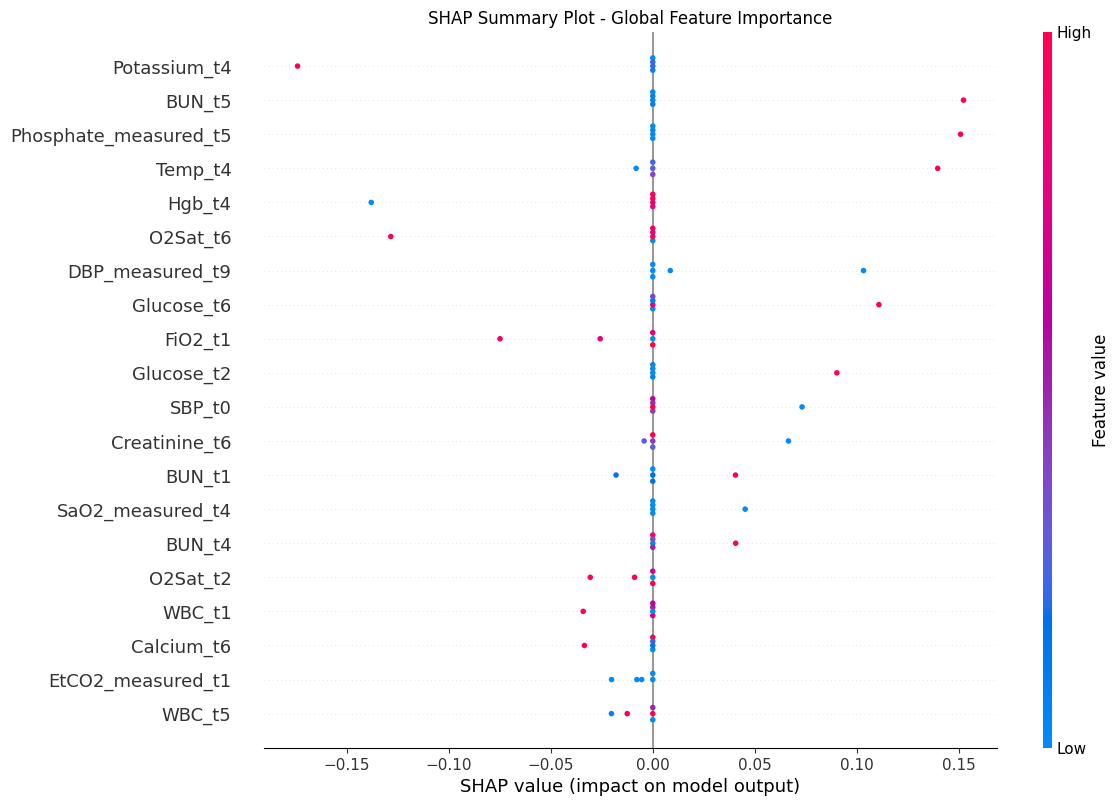

In [58]:
X_test_2d = X_test_scaled[:10].reshape(10, -1)
X_train_background_2d = X_train_scaled[np.random.choice(len(X_train_scaled), 300, replace=False)].reshape(300, -1)

def model_predict_proba(data_2d):
    data_3d = data_2d.reshape(-1, X_train_scaled.shape[1], X_train_scaled.shape[2])
    return final_model_gwo.predict(data_3d, verbose=0).ravel()

print("\nComputing SHAP explanations (using more background samples)...")
explainer = shap.KernelExplainer(model_predict_proba, X_train_background_2d)
shap_values = explainer.shap_values(X_test_2d[:5], nsamples=200)

shap.summary_plot(shap_values, X_test_2d[:5],
                  feature_names=[f"{feat}_t{t}" 
                                 for t in range(X_test_scaled.shape[1]) 
                                 for feat in feature_cols],
                  show=False, plot_size=(12, 8))
plt.title("SHAP Summary Plot - Global Feature Importance")
plt.show()

**GRAD CAM**

In [62]:
conv_layers = [layer.name for layer in final_model_gwo.layers if 'conv1d' in layer.name.lower()]
print(f"\nFound {len(conv_layers)} Conv1D layers: {conv_layers}")


Found 8 Conv1D layers: ['conv1d', 'conv1d_1', 'conv1d_2', 'conv1d_3', 'conv1d_4', 'conv1d_5', 'conv1d_6', 'conv1d_7']


In [64]:
def gradcam_heatmap(model, sample, layer_name):
    try:
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(layer_name).output, model.output]
        )
        
        with tf.GradientTape() as tape:
            conv_out, preds = grad_model(sample)
            pred_score = preds[0, 0]
        
        grads = tape.gradient(pred_score, conv_out)
        if grads is None:
            return None
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
        conv_out = conv_out[0]
        heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
        heatmap = tf.maximum(heatmap, 0)
        if tf.reduce_max(heatmap) > 0:
            heatmap = heatmap / tf.reduce_max(heatmap)
        
        return heatmap.numpy()
    except:
        return None

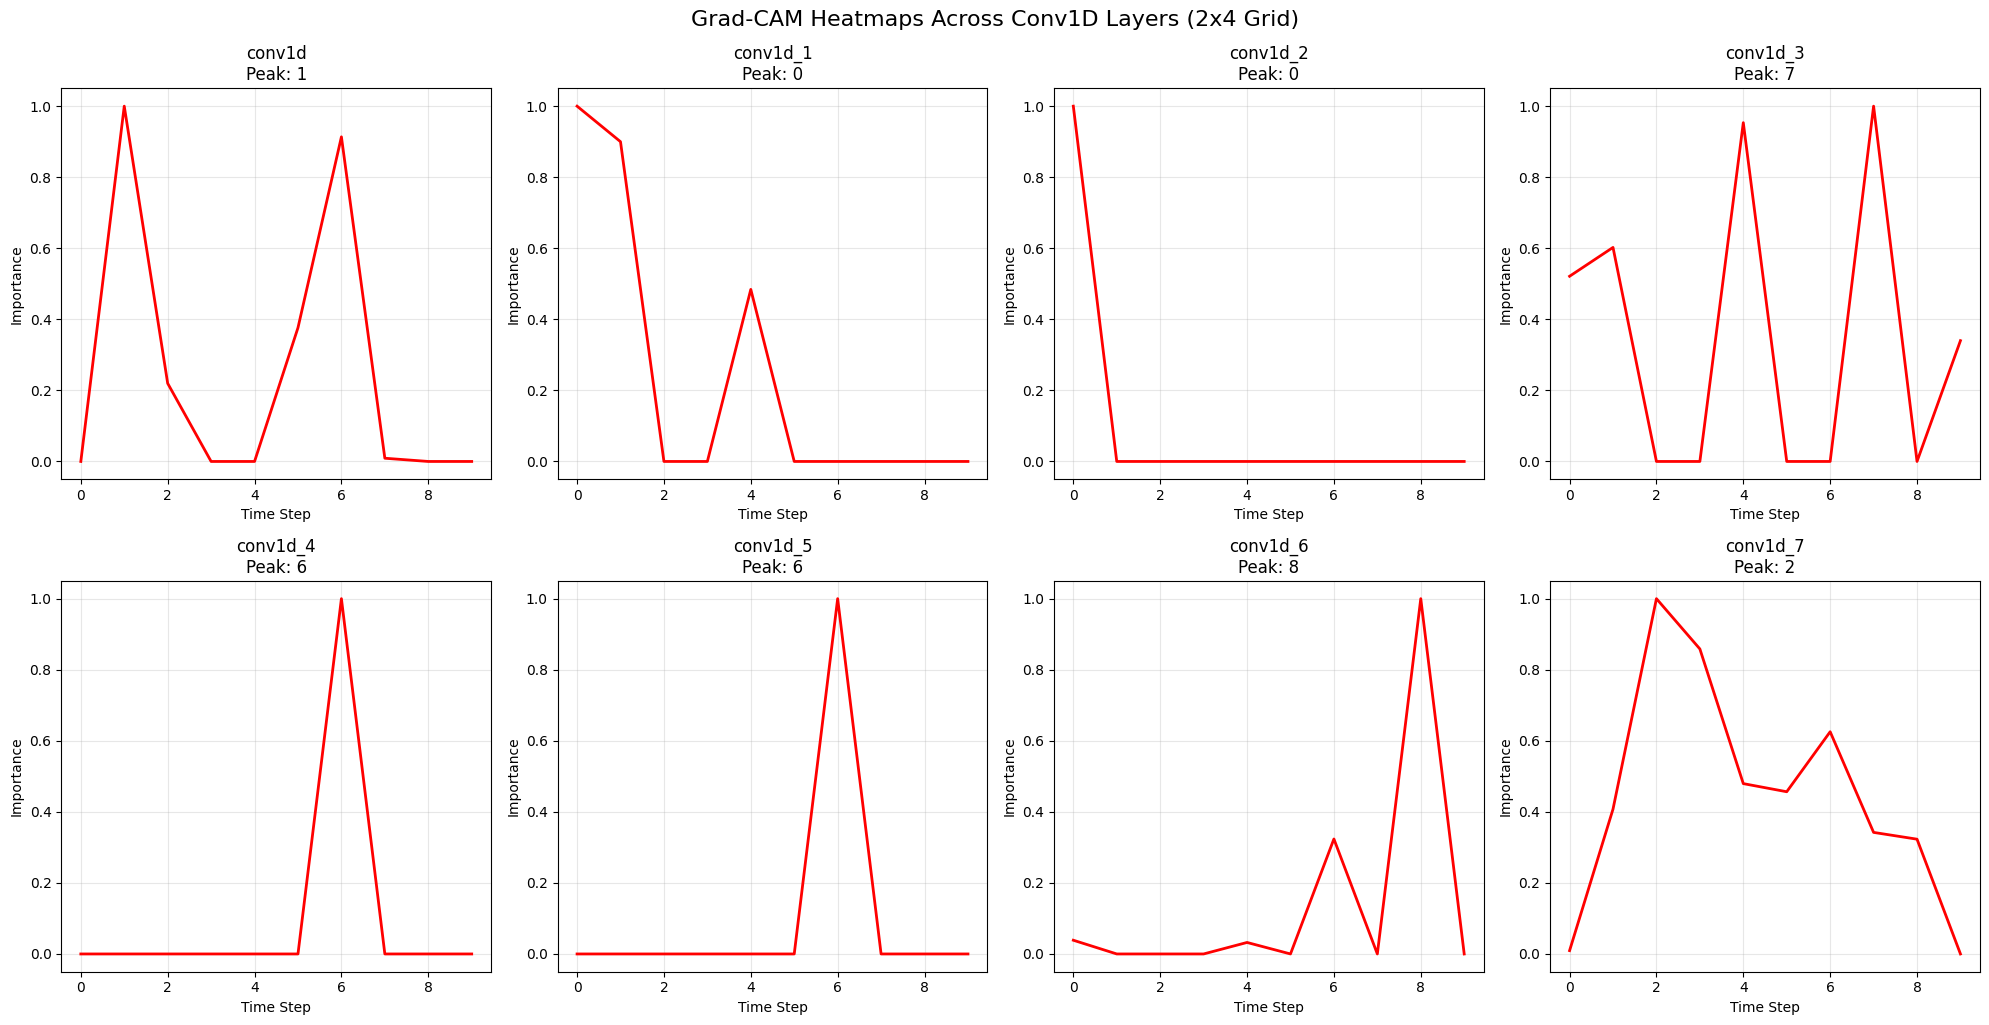


GWO optimization + XAI complete!
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final Test ROC AUC: 0.9798


In [65]:




sepsis_idx = np.where(y_test == 1)[0][0]
sample = X_test_scaled[sepsis_idx:sepsis_idx+1]

n_layers = len(conv_layers)
cols = 4
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()

for i, layer_name in enumerate(conv_layers):
    if i >= rows * cols:
        break
    ax = axes[i]
    heatmap = gradcam_heatmap(final_model_gwo, sample, layer_name)
    if heatmap is not None:
        ax.plot(heatmap, color='red', linewidth=2)
        ax.set_title(f"{layer_name}\nPeak: {np.argmax(heatmap)}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Importance")
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No signal/gradient", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{layer_name}\n(No signal)")

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Grad-CAM Heatmaps Across Conv1D Layers (2x4 Grid)", fontsize=16, y=1.02)
plt.show()

print("\nGWO optimization + XAI complete!")
print(f"Final Test ROC AUC: {roc_auc_score(y_test, final_model_gwo.predict(X_test_scaled).ravel()):.4f}")